In [83]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import scipy.fftpack as sf
import scipy.constants as sc

二维点目标分析

In [84]:
SAR_center_frequency = 1.27e+09
chirp_direction = -1
chirp_bandwidth = 1.4e+7
chirp_duration = 2.7e-5
chirp_slope = chirp_direction*chirp_bandwidth/chirp_duration
ADC_sampling_frequency = 1.600000e+7

azimuth_bandwidth_fraction = 0.8
pulse_repetition_frequency =2141.327623

R_0 = 872198.9383879999   
doppler_centroid_frequency = 130
#effective_radar_velocity 
Vg = 7174.508  
ratio_pv_ev = 1.06
#platform_radar_velocity 
Vs = Vg*ratio_pv_ev

La = 10

In [85]:
lambda_len = sc.c/SAR_center_frequency
theta_sqc = np.arcsin(lambda_len*doppler_centroid_frequency/(2*Vs))
theta_rc = theta_sqc/np.sqrt(ratio_pv_ev)

eta_c = -R_0*np.tan(theta_sqc)/Vg
R_etac = np.sqrt(R_0**2+ Vs*Vg*eta_c**2)

Ta = 0.886*lambda_len*R_etac/(La*Vg*np.cos(theta_rc))
T1 = eta_c - Ta/2
T2 = eta_c + Ta/2

print('eta_c:',eta_c)
print('theta_sqc:',theta_sqc*180/np.pi,'theta_rc:',theta_rc*180/np.pi)
print('T1:',T1,'T2',T2)

eta_c: -0.24527690792662663
theta_sqc: 0.11559931915044153 theta_rc: 0.11227998438894919
T1: -1.5165706482878638 T2 1.0260168324346106


range 1728 azimuth 5444


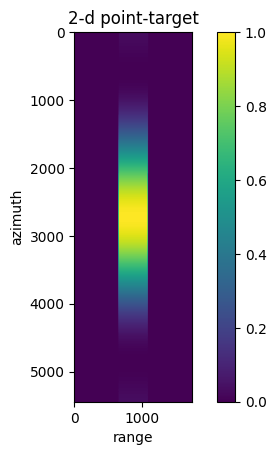

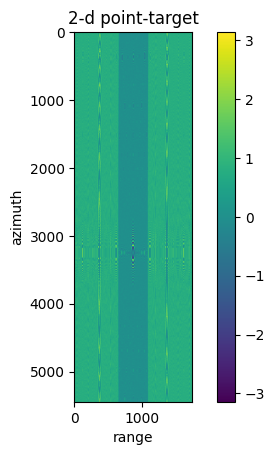

In [86]:
N_range = int(4*chirp_duration*ADC_sampling_frequency)
N_azimuth = int(Ta*pulse_repetition_frequency)
print('range',N_range,'azimuth',N_azimuth)

range_time = np.linspace(-2*chirp_duration,2*chirp_duration - 1/ADC_sampling_frequency,N_range).reshape(1,N_range) 
azimuth_time = np.linspace(T1,T2-1/pulse_repetition_frequency,N_azimuth).reshape(N_azimuth,1)
R_eta = np.sqrt(R_0**2 + Vs*Vg*azimuth_time**2)
rectan = (np.abs(range_time-2*(R_eta-R_0)/sc.c)<=chirp_duration/2)

# plt.figure()
# A_2d,R_2d = np.meshgrid(range_time,azimuth_time)
# plt.pcolor(A_2d,R_2d,rectan)
index = (range_time<chirp_duration/2)*(range_time>=-chirp_duration/2)
index = np.where(index ==True)
x_chirp = np.exp(1j*np.pi*chirp_slope*(range_time[0,index[1]])**2)
S_2d = rectan*np.sinc(azimuth_time-eta_c)**2*np.exp(-1j*4*np.pi*R_eta*SAR_center_frequency/sc.c)\
        *np.exp(1j*np.pi*chirp_slope*(range_time-2*(R_eta-R_0)/sc.c)**2)
plt.figure()
plt.imshow(np.abs(S_2d))
plt.title('2-d point-target')
plt.xlabel('range')
plt.ylabel('azimuth')
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(np.angle(S_2d))
plt.title('2-d point-target')
plt.xlabel('range')
plt.ylabel('azimuth')
plt.colorbar()
plt.show()


# plt.figure()
# plt.plot(azimuth_time,np.real(S_2d[:,400]))


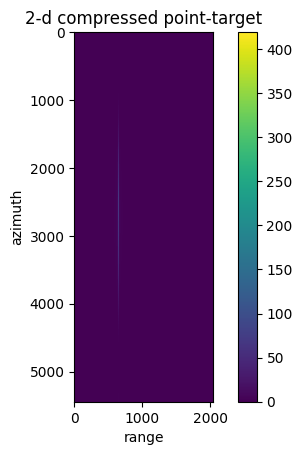

In [87]:
N_range_fft = int(2**np.ceil(np.log2(N_range)))
N_azimuth_fft = int(2**np.ceil(np.log2(N_azimuth)))
S_2d_rf = sf.fft(S_2d,N_range_fft,axis=1)
# h_2_fft = np.conjugate(sf.fft(S_2d,N_range_fft,axis=1))
h_2_fft = np.conjugate(sf.fft(x_chirp,N_range_fft))
S_mf = sf.ifft(S_2d_rf*h_2_fft,axis=1)
plt.figure()
plt.imshow((np.abs(S_mf)))
plt.title('2-d compressed point-target')
plt.xlabel('range')
plt.ylabel('azimuth')
plt.colorbar()
plt.show()

距离多普勒域

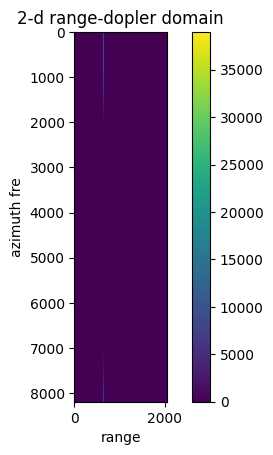

In [88]:
S_rdf = sf.fft(S_mf,N_azimuth_fft,axis=0)
f_azi = sf.fftfreq(N_azimuth_fft,1/pulse_repetition_frequency)
f_azi = f_azi + np.round((-f_azi+doppler_centroid_frequency)/pulse_repetition_frequency)*pulse_repetition_frequency
# f_azi = f_azi + np.round((doppler_centroid_frequency)/pulse_repetition_frequency)*pulse_repetition_frequency
plt.figure()
plt.imshow((np.abs(S_rdf)))
plt.title('2-d range-dopler domain')
plt.xlabel('range')
plt.ylabel('azimuth fre')
plt.colorbar()
plt.show()

二维多普勒

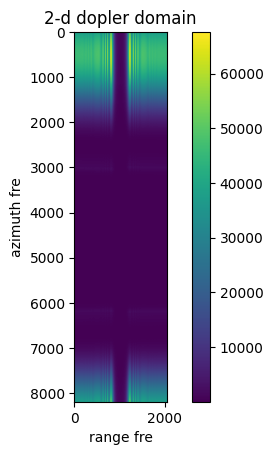

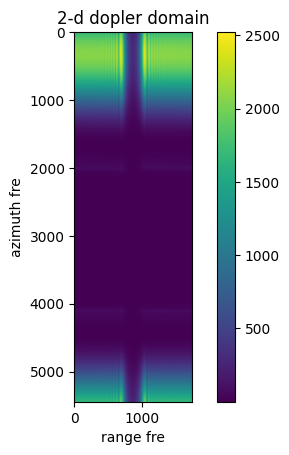

In [89]:
S_2df2 = sf.fft2(S_2d)
S_2df = sf.fft(S_rdf,N_range_fft,axis=-1)
plt.figure()
plt.imshow((np.abs(S_2df)))
plt.title('2-d dopler domain')
plt.xlabel('range fre')
plt.ylabel('azimuth fre')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow((np.abs(S_2df2)))
plt.title('2-d dopler domain')
plt.xlabel('range fre')
plt.ylabel('azimuth fre')
plt.colorbar()
plt.show()

距离徙动矫正

range_pixel 9.3685143125
RCM_total: 7.678902130581405
17.0


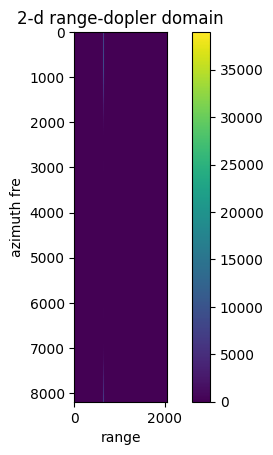

In [90]:
range_pixel = sc.c/ADC_sampling_frequency/2
range_shift = Vs*Vg/2/R_0*(np.abs(eta_c)+Ta/2)**2/range_pixel
print('range_pixel',range_pixel)
print('RCM_total:',range_shift)

interp_num = 16
interp_step = 16
interp_pos = np.linspace(0,1-1/interp_step,interp_step)
interp_ind = np.arange(-interp_num/2,interp_num/2,1)
interp_xvalue = interp_ind.reshape(1,interp_num) - interp_pos.reshape(interp_step,1)
interp_sinc = np.sinc(interp_xvalue)
window = ss.get_window(window=('kaiser',0.25),Nx=interp_num)

RCM_Q  = np.round(lambda_len**2*R_0/(8*Vs*Vg)*f_azi**2/range_pixel)
print(RCM_Q.max())

N_pad = 128
S_rdf_c = np.zeros_like(S_rdf)
S_rdf_pad = np.zeros([S_rdf.shape[0],N_pad+S_rdf.shape[1]],dtype=np.complex128)
S_rdf_pad[:,0:int(N_pad/2)] = 0
S_rdf_pad[:,S_rdf.shape[1]+int(N_pad/2):N_pad+S_rdf.shape[1]] = 0
S_rdf_pad[:,int(N_pad/2):S_rdf.shape[1]+int(N_pad/2)] = S_rdf

for i in range(len(RCM_Q)):
    points = int(np.floor(RCM_Q[i]))
    offset = int(np.round((RCM_Q[i] - np.floor(RCM_Q[i]))*interp_step))
    points += offset//interp_step
    offset = np.remainder(offset,interp_step)
    for j in range(S_rdf_c.shape[1]):
        S_rdf_c[i,j] = np.sum(S_rdf_pad[i,int(N_pad/2)+j+points-int(interp_num/2):int(N_pad/2)+j+points+int(interp_num/2)]*interp_sinc[offset,:]*window)

plt.figure()
plt.imshow((np.abs(S_rdf_c)))
plt.title('2-d range-dopler domain')
plt.xlabel('range')
plt.ylabel('azimuth fre')
plt.colorbar()
plt.show()

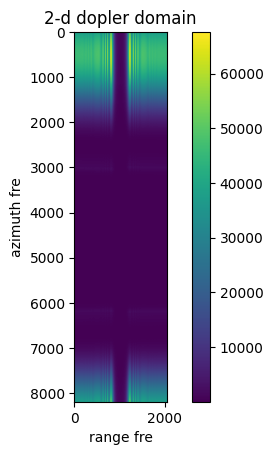

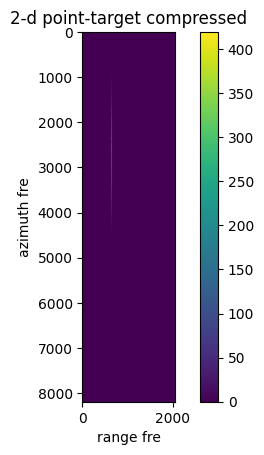

In [91]:
S_2df_c = sf.fft(S_rdf_c,N_range_fft)
plt.figure()
plt.imshow((np.abs(S_2df_c)))
plt.title('2-d dopler domain')
plt.xlabel('range fre')
plt.ylabel('azimuth fre')
plt.colorbar()
plt.show()
# f_range = sf.fftfreq(N_range_fft,1/ADC_sampling_frequency)
# h_3_fft = np.exp(1j*np.pi*((f_range)**2)/chirp_slope)*np.exp(1j*np.pi/4)
# width = int(np.abs(chirp_slope*chirp_duration)/(ADC_sampling_frequency/N_range_fft)/2)
# h_3_fft[int(N_range_fft/2)-width:int(N_range_fft/2)+width]=0
# h_3_fft = h_3_fft.reshape(1,N_range_fft)
# S_mf = sf.ifft2(S_2df_c*h_3_fft)
S_mf_C = sf.ifft2(S_2df_c)

plt.figure()
plt.imshow((np.abs(S_mf_C)))
plt.title('2-d point-target compressed')
plt.xlabel('range fre')
plt.ylabel('azimuth fre')
plt.colorbar()
plt.show()


观察压缩位置信号

2830 649


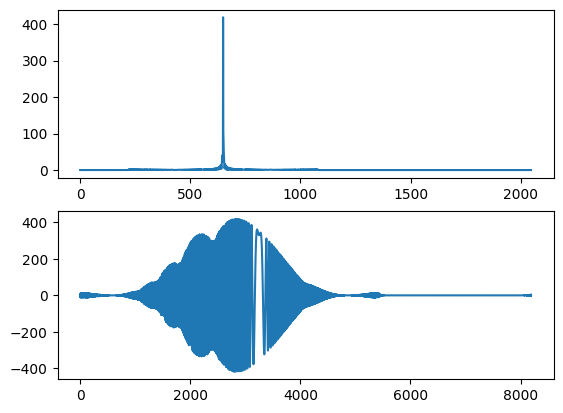

In [92]:
print(np.argmax(S_mf_C)//N_range_fft,np.mod(np.argmax(S_mf_C),N_range_fft))
y, x = np.argmax(S_mf_C)//N_range_fft,np.mod(np.argmax(S_mf_C),N_range_fft)
plt.figure()
plt.subplot(2,1,1)
plt.plot(range(N_range_fft),np.abs(S_mf_C[y,:]))
# plt.xlim(600,700)

plt.subplot(2,1,2)
plt.plot(range(N_azimuth_fft),np.real(S_mf_C[:,x]))

方位向压缩

max position: 3247 649


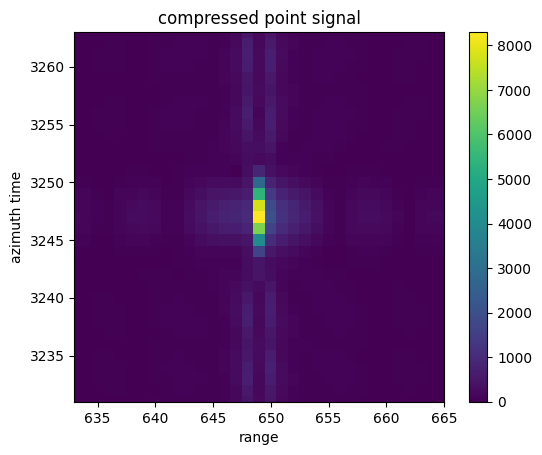

In [93]:

Ka = 2*(Vs*Vg)*SAR_center_frequency/sc.c/R_0
Haz = np.exp(-1j*np.pi*f_azi**2/Ka).reshape(N_azimuth_fft,1)

S_mf_2 = sf.ifft(S_rdf_c*Haz,axis=0)
y, x = np.argmax(np.abs(S_mf_2))//N_range_fft, np.mod(np.argmax(np.abs(S_mf_2)),N_range_fft)
print('max position:',y,x)
plt.figure()
plt.imshow((np.abs(S_mf_2)))
plt.title('compressed point signal')
plt.xlabel('range')
plt.ylabel('azimuth time')
plt.colorbar()
plt.xlim(x-16,x+16)
plt.ylim(y-16,y+16)
plt.show()

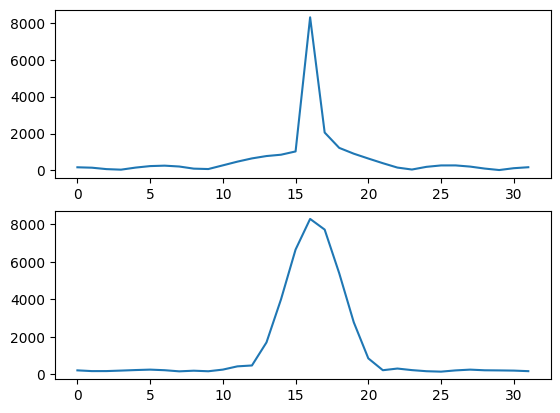

In [94]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(range(32),np.abs(S_mf_2[y,x-16:x+16]))

plt.subplot(2,1,2)
plt.plot(range(32),np.abs(S_mf_2[y-16:y+16,x]))


16 upsampling

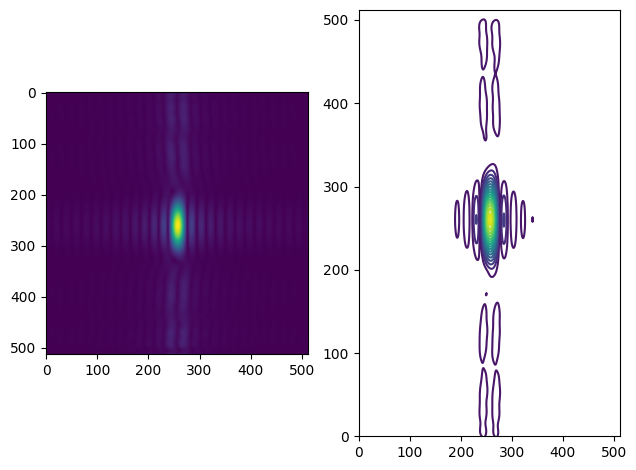

In [95]:

K = 16
N = 32
C_point = S_mf_2[y-16:y+16,x-16:x+16]
C_2ft = sf.fft2(C_point)
C_rp_fft = np.zeros([N,K*N],dtype=np.complex128)
for i in range(N):
    x_min = np.argmin(np.abs(C_2ft[i,:]))
    C_rp_fft[i,0:x_min] = C_2ft[i,0:x_min]
    C_rp_fft[i,K*N-(N-x_min):K*N] = C_2ft[i,x_min:N]

C_rp_fft_u = np.zeros([K*N,K*N],dtype=np.complex128)
for j in range(K*N):
    y_min = np.argmin(np.abs(C_rp_fft[:,j]))
    C_rp_fft_u[0:y_min,j] = C_rp_fft[0:y_min,j]
    C_rp_fft_u[K*N-(N-y_min):K*N,j] = C_rp_fft[y_min:N,j]
c_ups = sf.ifft2(C_rp_fft_u )
plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.abs(c_ups))
# plt.xlim(128,128+256)
# plt.ylim(128,128+256)

plt.subplot(1,2,2)
plt.contour((np.linspace(0,K*N,K*N)),(np.linspace(0,K*N,K*N)),\
             np.abs(c_ups),levels = 20)
# plt.xlim(128,128+256)
# plt.ylim(128,128+256)
# plt.contour((np.linspace(0,K*N,K*N))[int(K*N/2-N):int(K*N/2+N)],(np.linspace(0,K*N,K*N))[int(K*N/2-N):int(K*N/2+N)],\
#             np.abs(x_pad[int(K*N/2-N):int(K*N/2+N),int(K*N/2-N):int(K*N/2+N)]))
# plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()

max position: 260 257


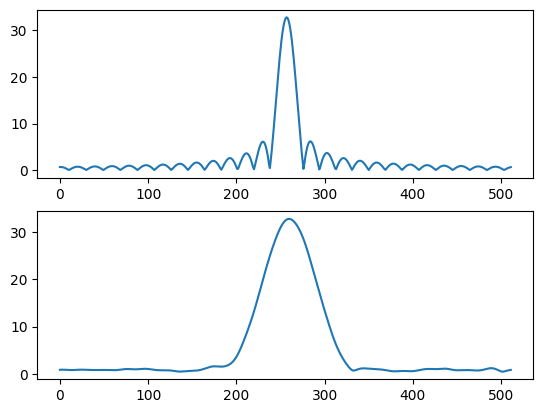

In [96]:
y_ups, x_ups = np.argmax(np.abs(c_ups))//(K*N), np.mod(np.argmax(np.abs(c_ups)),(K*N))

print('max position:',y_ups,x_ups)
plt.figure()
plt.subplot(2,1,1)
plt.plot(range(K*N),np.abs(c_ups[y_ups,:]))

plt.subplot(2,1,2)
plt.plot(range(K*N),np.abs(c_ups[:,x_ups]))

